# <center> Обучение с учителем. Классификация.
## <center> Предсказываем вероятность открытия депозита клиентом банка.
<center> <img src=https://avatars.dzeninfra.ru/get-zen_doc/271828/pub_6518470351b4a948e5a91785_6518d60f6b0b253b3609b9c2/scale_1200>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.feature_selection import SelectKBest, f_classif

%matplotlib inline
plt.style.use('seaborn')

c:\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [4]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


У признака "balance" 25 пропущенных значений. Также пропущенные (неизвестные) значения могут присутствовать неявным образом. Это значит, что они могут быть закодированы каким-то словом или набором символов. Часто это не является проблемой, но это необходимо выявить. 

In [6]:
types = df.dtypes
cat_features = list(types[types == 'object'].index)
cat_features

['job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

In [7]:
for feature in cat_features:
    print(df[feature].value_counts()) 
    print('\n')

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64


married     6351
single      3518
divorced    1293
Name: marital, dtype: int64


secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64


no     10994
yes      168
Name: default, dtype: int64


0  $            774
 1,00 $          39
 3,00 $          34
 2,00 $          34
 4,00 $          29
               ... 
 1 641,00 $       1
 5 517,00 $       1
 8 332,00 $       1
 4 859,00 $       1
-134,00 $         1
Name: balance, Length: 3802, dtype: int64


no     5881
yes    5281
Name: housing, dtype: int64


no     9702
yes    1460
Name: loan, dtype: int64


cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64


may    2824
aug 

Неявные пропуски в категориальных признаках (job, education, contact, poutcome) помечены как 'unknown'. Признак 'balance' представлен в некорректной форме.

Преобразуем признак balance для корректного считывания.

In [8]:
df['balance'] = df['balance'].apply(lambda x: str(x).split(',')[0].replace(' ','') if ',' in str(x) else str(x).replace('$',''))
df['balance'] = df['balance'].astype('float')

Обработаем пропуски в признаке balance , заменив их на медианные значения по данному признаку.

In [9]:
df['balance'] = df['balance'].fillna(df['balance'].median())

Обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения.

In [10]:
df['job'] = df['job'].apply(lambda x: df['job'].mode().loc[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode().loc[0] if x == 'unknown' else x)

Изучим признак 'balance' на предмет выбросов. Для обработки выбросов воспользуемся методом Тьюки.

In [11]:
quartile_1, quartile_3 = df['balance'].quantile(0.25), df['balance'].quantile(0.75)
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (1.5 * iqr)
upper_bound = quartile_3 + (1.5 * iqr)
print(lower_bound, upper_bound)
df_cleaned = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

-2241.0 4063.0


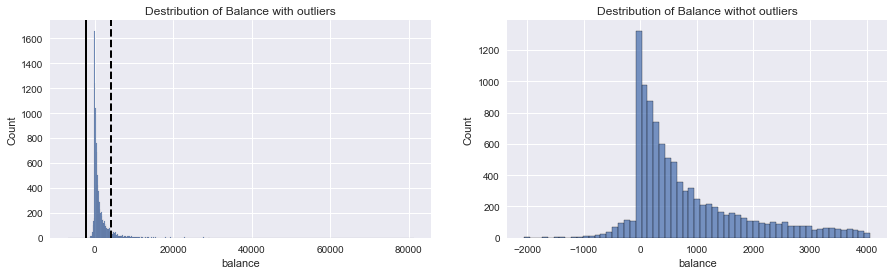

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(data=df, x='balance', ax=axes[0])
sns.histplot(data=df_cleaned, x='balance', ax=axes[1])
axes[0].axvline(lower_bound, color='k', lw=2)
axes[0].axvline(upper_bound, color='k', ls='--', lw=2)
axes[0].set_title('Destribution of Balance with outliers')
axes[1].set_title('Destribution of Balance withot outliers');

## Часть 2:  Разведывательный анализ

Цель этого шага — понять слабые и сильные стороны предоставленных данных, определить их достаточность, оценить взаимосвязи между признаками и предложить идеи, как их использовать.

Изучим распределение целевой переменной на предмет несбалансированности.

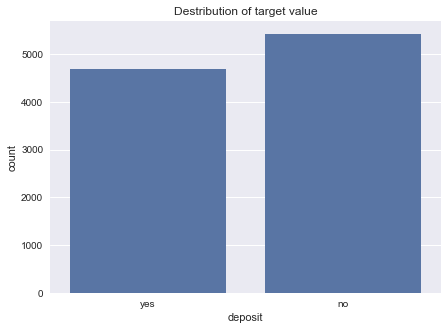

In [13]:
fig, axes = plt.subplots(figsize=(7,5))
sns.countplot(data=df_cleaned, x='deposit')
axes.set_title('Destribution of target value');

Выводим описательные статистики для числовых и категориальных признаков.

In [14]:
df_cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Исходя из данных максмальный возраст клиента банка составляет 95 лет, минимальная продолжительность разговора составляет 2 секунды, достаточно высокая вариативность данных наблюдается у признаков баланса, продолжительности звонка. 

Для каждого числового признака построим гистограмму и boxplot для наглядности. 

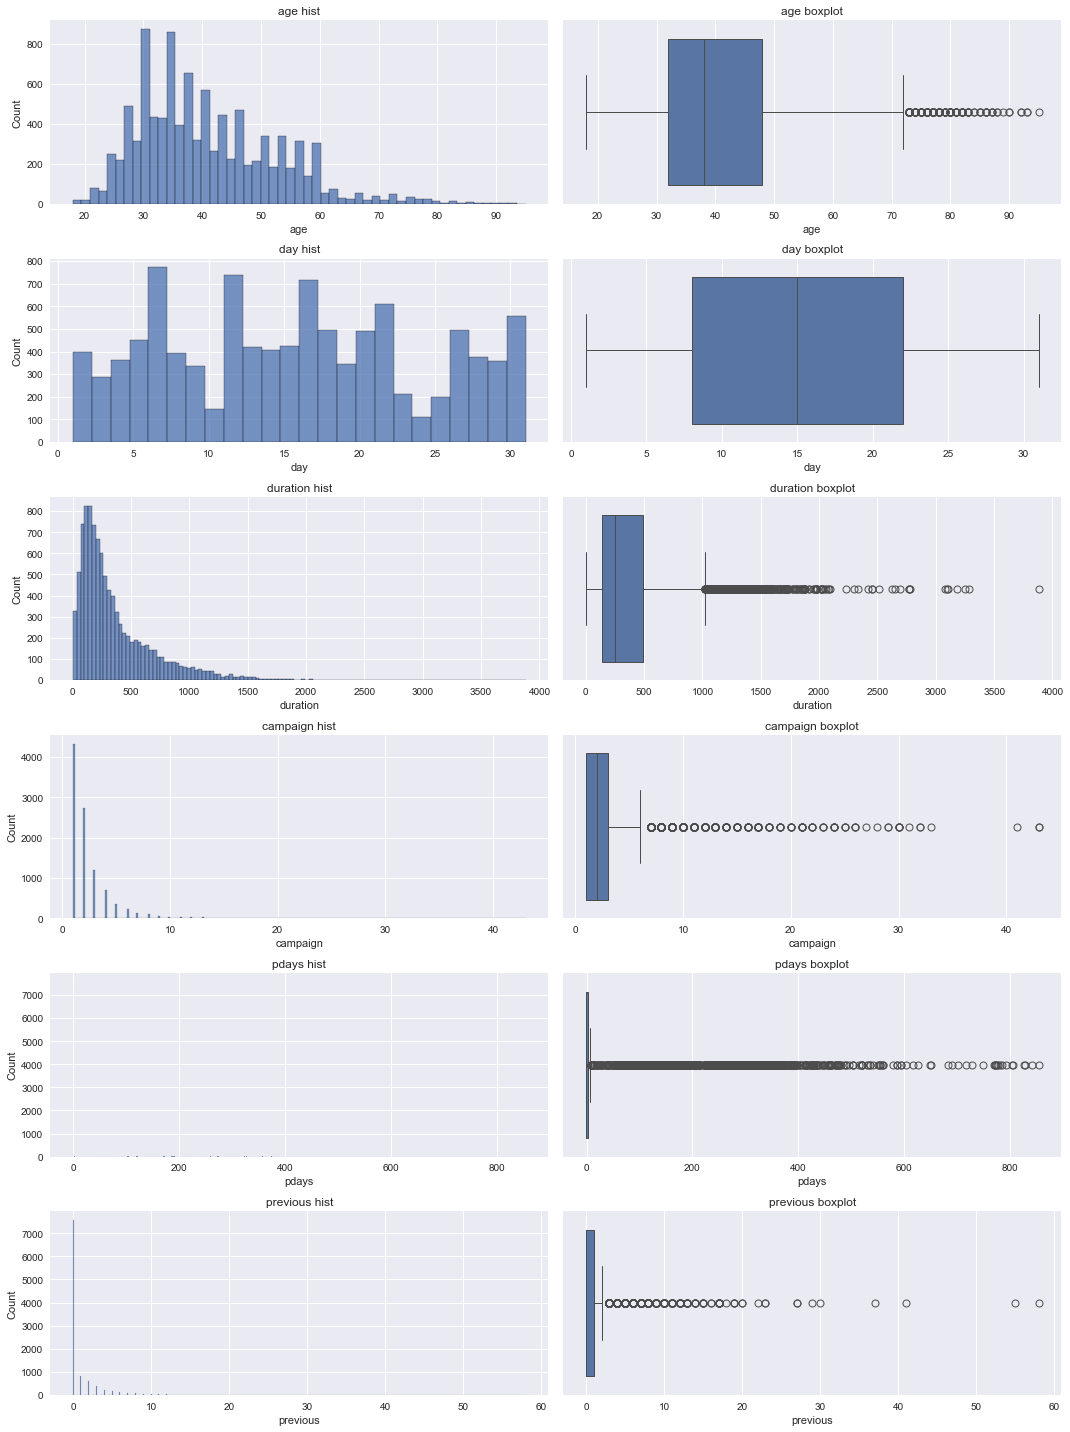

In [15]:
num_features = list(types[(types != 'object')].index)
n = len(num_features)
fig, axes = plt.subplots(n, 2, figsize=(15, 20))
for i , feature in enumerate(num_features):
    histplot = sns.histplot(data=df_cleaned, x=feature, ax=axes[i][0])
    histplot.set_title(f"{feature} hist")
    boxplot = sns.boxplot(data=df_cleaned, x=feature, ax=axes[i][1])
    boxplot.set_title(f"{feature} boxplot")
plt.tight_layout()

In [16]:
df_cleaned.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Исслудуем для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

In [17]:
status = df_cleaned.groupby('poutcome')['deposit'].value_counts().unstack()
status

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


Со статусом "success" предыдущей маркетинговой клиенты банка наиболее склонны открывать вклад и в текущей маркетинговой компании.

Исследуем в каком месяце чаще всего отказывались от предложения открыть депозит.

In [18]:
month = df_cleaned.groupby('month')['deposit'].value_counts(normalize=True).unstack()
month

deposit,no,yes
month,,
apr,0.381928,0.618072
aug,0.559567,0.440433
dec,0.096774,0.903226
feb,0.455571,0.544429
jan,0.608150,0.391850
jul,0.589563,0.410437
jun,0.548913,0.451087
mar,0.101266,0.898734
may,0.678640,0.321360


Месяц май возможно является не лучшим месяцем для проведения подобных акций, и это стоит отметить.

Создадим возрастные группы и определим, в каких группах клиенты более склонны открывать депозит, чем отказываться от предложения.

<AxesSubplot:xlabel='age_group', ylabel='count'>

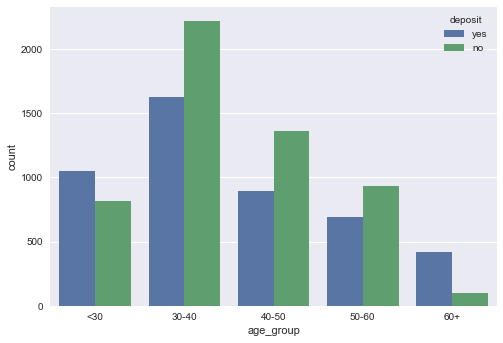

In [19]:
df_cleaned['age_group'] = pd.cut(df_cleaned.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(data=df_cleaned, x="age_group", hue="deposit")

Две возрастные группы ('<30' и '60+') более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения.

Построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса, образования, вида профессиональной занятости.

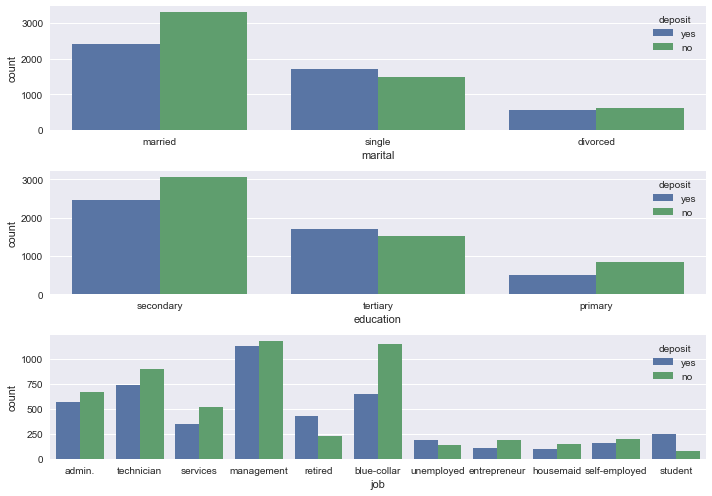

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(10, 7))
sns.countplot(data=df_cleaned, x='marital', hue='deposit', ax=axes[0])
sns.countplot(data=df_cleaned, x='education', hue='deposit', ax=axes[1])
sns.countplot(data=df_cleaned, x='job', hue='deposit', ax=axes[2]);
fig.tight_layout()

Клиенты с семейным статусом "single", уровнем образования "tertiary", уровнем занятости "student", "unemployed", "retired" более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения.

Определим люди с каким образованием и семейным статусом наиболее многочисленны в разрезе открытия депозита.

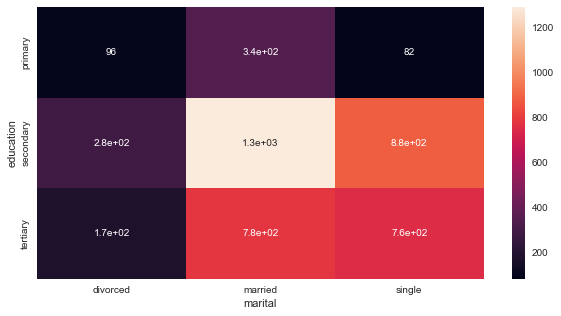

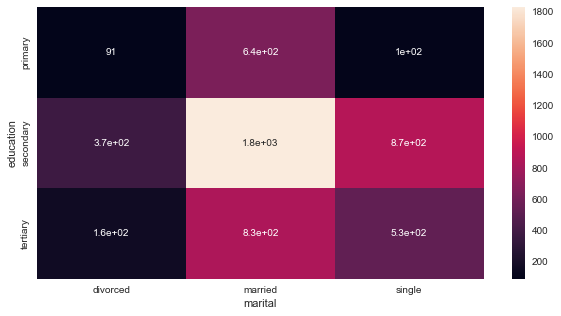

In [21]:
df_with_deposit = df_cleaned[df_cleaned['deposit'] == 'yes']
df_without_deposit = df_cleaned[df_cleaned['deposit'] == 'no']
crosstable_with_deposit = pd.crosstab(index=df_with_deposit['education'], columns=df_with_deposit['marital'])
crosstable_without_deposit = pd.crosstab(index=df_without_deposit['education'], columns=df_without_deposit['marital'])
fig = plt.figure(figsize=(10, 5))
sns.heatmap(crosstable_with_deposit, annot=True);
fig = plt.figure(figsize=(10, 5))
sns.heatmap(crosstable_without_deposit, annot=True);

Наиболее многочиленной группой являются клиенты в браке со средним уровнем образования.

## Часть 3: преобразование данных

Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: education.

Обработаем его с помощью метода LabelEncoder, используя метод без дополнительных настроек.

In [22]:
le = LabelEncoder()
df_cleaned['education'] = le.fit_transform(df_cleaned[['education']])

Переменную для возраста. Обработаем по такому же принципу, чтобы её можно было использовать при обучении модели.

In [23]:
df_cleaned['age_group'] = le.fit_transform(df_cleaned[['age_group']])
df_cleaned.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2


Преобразуем бинарные переменные (default, housing, loan, deposit) в представление из нулей и единиц.

In [24]:
df_cleaned['default'] = df_cleaned['default'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleaned['housing'] = df_cleaned['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleaned['loan'] = df_cleaned['loan'].apply(lambda x: 1 if x == 'yes' else 0)
df_cleaned['deposit'] = df_cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

Преобразуем номинальные переменные ('job'; 'marital'; 'contact'; 'month'; 'poutcome'), которые могут принимать несколько различных значений. Создадим для них dummy-переменные и добавим их в набор данных.

In [25]:
dummy_data = pd.get_dummies(data=df_cleaned, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

Построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности. Будем считать достаточно сильной корреляцию не менее 0.9.

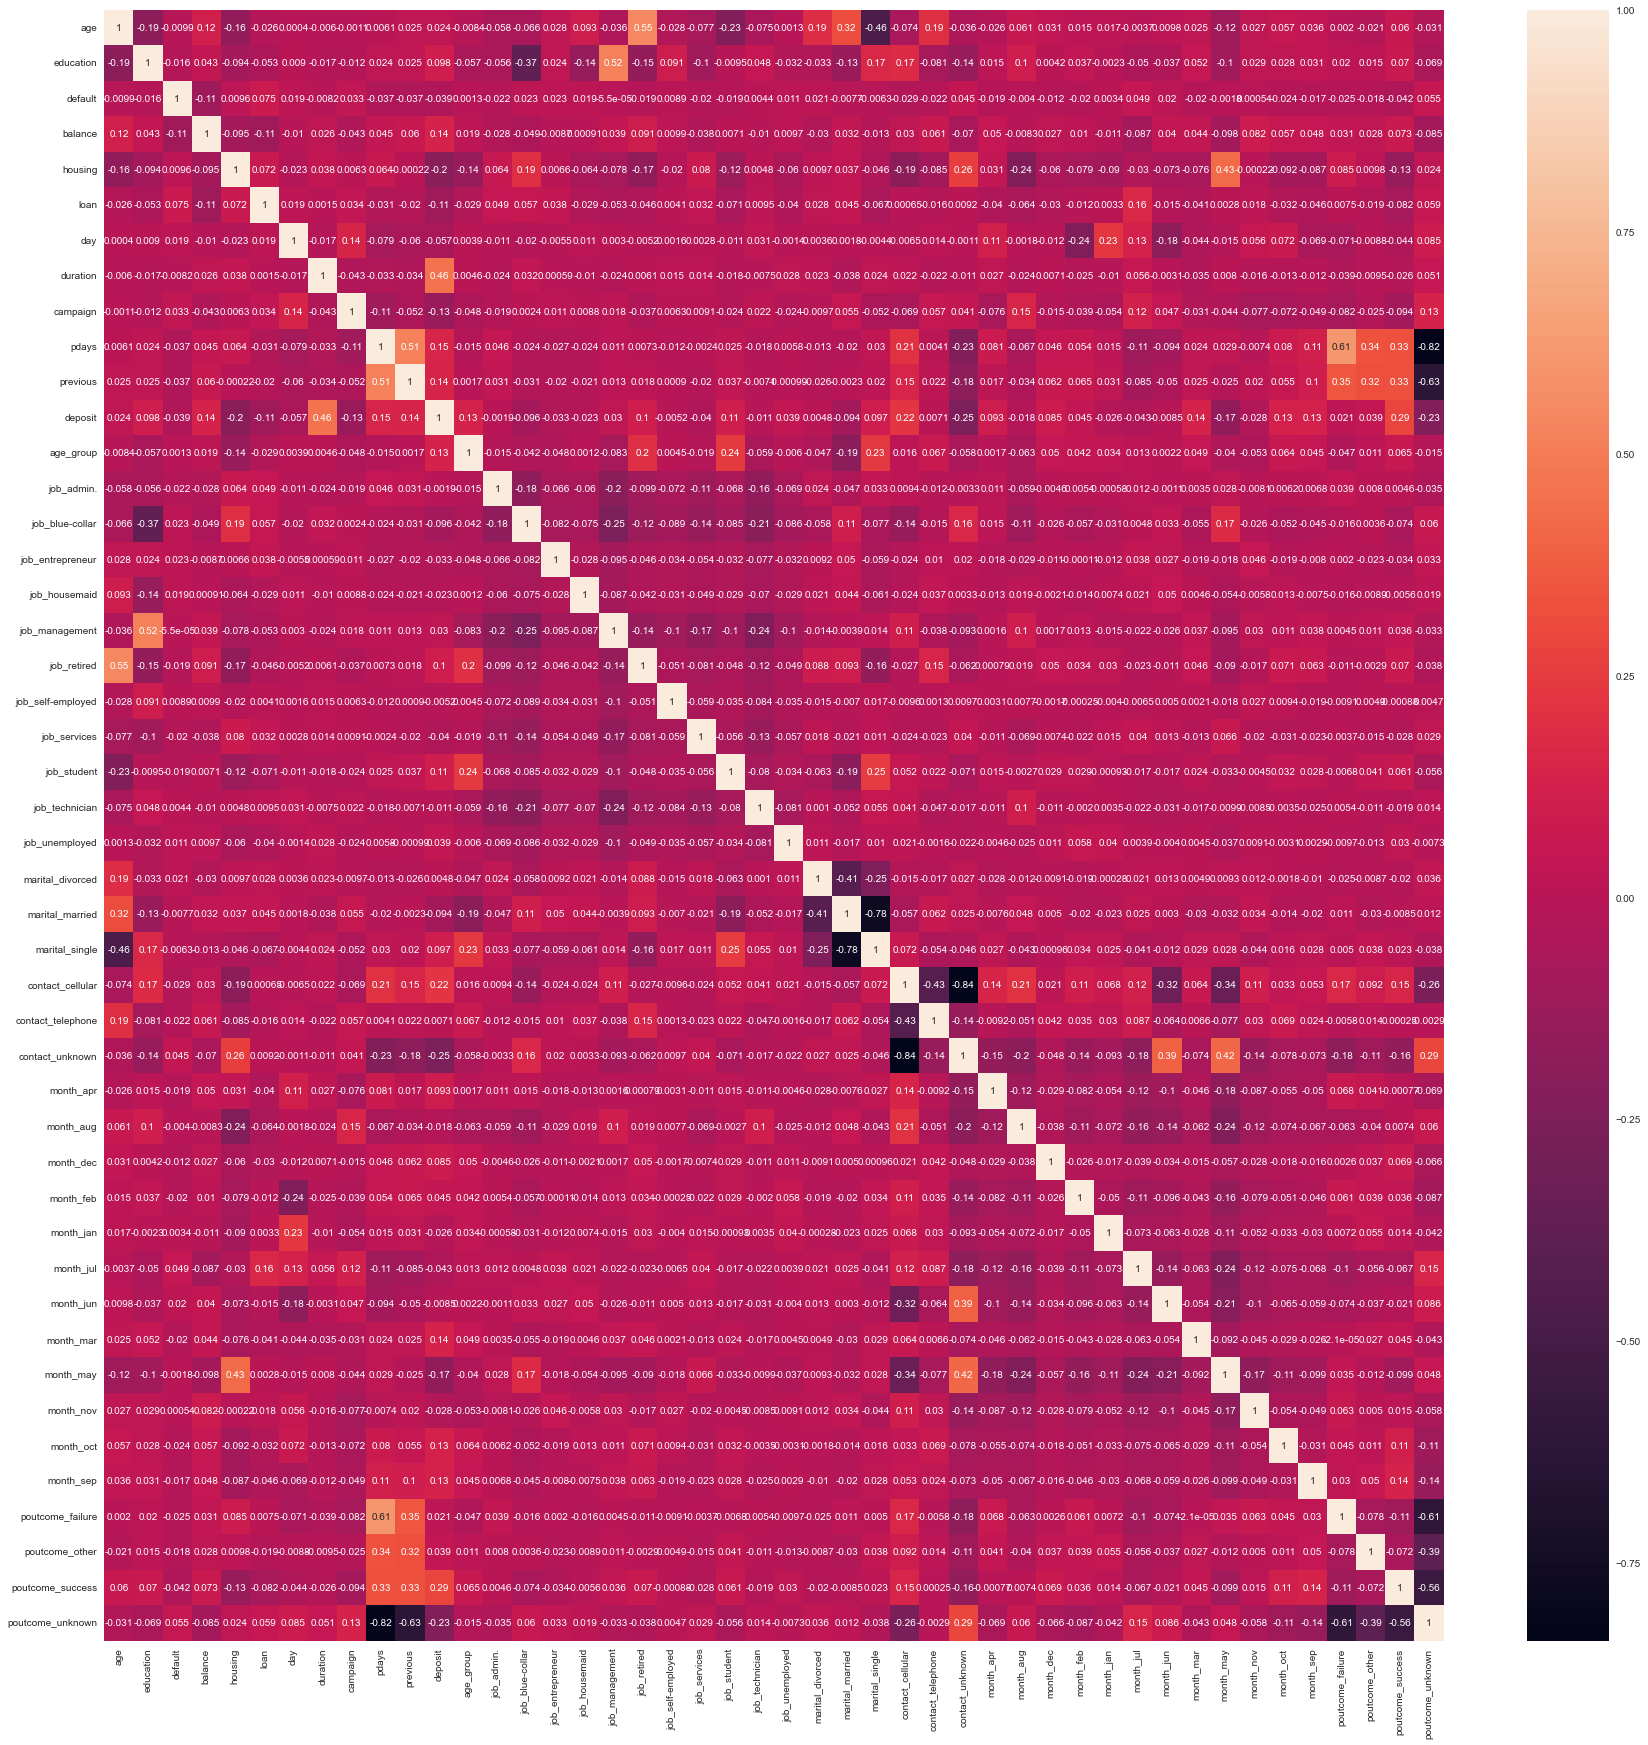

In [26]:
fig, axes = plt.subplots(figsize=(30,30))
sns.heatmap(dummy_data.corr(), annot=True);

Определим целевую переменную и предикторы, а также разделим выборку на обучающую и тестовую.

In [27]:
X = dummy_data.drop(['deposit'], axis=1)
y = dummy_data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

C помощью метода SelectKBest отберем 15 наиболее связанных с целевой переменной.

In [28]:
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train,y_train)
best_features = selector.get_feature_names_out()

X = dummy_data[best_features]
y = dummy_data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

Нормализуем данные с помощью minmaxsxaler.

In [29]:
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)
X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

Обучим логистическую регрессию и рассчитаем метрики качества.

In [30]:
lg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
lg.fit(X_train_scaled, y_train)
y_test_pred = lg.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Accuracy: 0.81


Обучим решающие деревья и рассчитаем метрики качества.

In [31]:
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = dt.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Подберем оптимальные параметры с помощью метода gridsearch.

In [32]:
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
            }
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
%time grid_search.fit(X_train_scaled, y_train) 
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 203 ms
Wall time: 2.02 s
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

Используем для классификации модель случайного леса.

In [33]:
rf = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=5, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)
y_test_pred = rf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Используем для классификации градиентный бустинг и сравним качество со случайным лесом.

In [34]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)
y_test_pred = gb.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Объединим уже известные алгоритмы с помощью стекинга. 

In [35]:
estimators = [
    ('lg',  lg),
    ('gb',  gb),
    ('dt', dt)
]

sf = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=lg
)

sf.fit(X_train_scaled, y_train)
y_test_pred = sf.predict(X_test_scaled)
print('precision на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

precision на тестовом наборе: 0.81


Оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга.

In [36]:
data = pd.DataFrame({
    'Features': X.columns,
    'Feature_importance': gb.feature_importances_
})
data

,Features,Feature_importance
0,balance,0.057952
1,housing,0.047725
2,duration,0.507106
3,campaign,0.014777
4,pdays,0.055077
5,previous,0.008449
6,age_group,0.039902
7,contact_cellular,0.003620
8,contact_unknown,0.072582
9,month_mar,0.027819


Реализуем оптимизацию гиперпараметров с помощью Optuna. Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [37]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [38]:
%%time
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

[I 2024-09-06 12:36:59,794] A new study created in memory with name: RandomForestClassifier
[I 2024-09-06 12:37:00,520] Trial 0 finished with value: 0.8498982626389106 and parameters: {'n_estimators': 139, 'max_depth': 17, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8498982626389106.
[I 2024-09-06 12:37:01,470] Trial 1 finished with value: 0.8440539692500785 and parameters: {'n_estimators': 185, 'max_depth': 11, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8498982626389106.
[I 2024-09-06 12:37:02,055] Trial 2 finished with value: 0.8616871978793077 and parameters: {'n_estimators': 101, 'max_depth': 17, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8616871978793077.
[I 2024-09-06 12:37:02,633] Trial 3 finished with value: 0.8469034894687205 and parameters: {'n_estimators': 111, 'max_depth': 12, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.8616871978793077.
[I 2024-09-06 12:37:03,457] Trial 4 finished with value: 0.866437284954645 and parameters: {'n_

CPU times: total: 19.6 s
Wall time: 21.1 s


In [39]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 183, 'max_depth': 27, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [40]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82
accuracy на тестовом наборе: 0.83
